In [4]:
import sys
import math
import numpy as np
from collections import deque
from tqdm import tqdm
import pygame
import json
import os.path
import matplotlib.pyplot as plt
import random 
import matplotlib.animation as animation
import pygame
import pygame.gfxdraw

Paramcar={"carheight":5,"carlength":5,"xcenterpos" :2.5,"ycenterpos":50,"place_in_road":1,"car_frequency":0.1,"v0":30 }
Paramtruck={"carheight":5,"carlength":10,"xcenterpos" :5,"ycenterpos":50,"place_in_road":1,"car_frequency":0.1,"v0":20 }
Paramdrivertruck={"maxspeed":90,"delta":5,"jamd":5,"maxa":2,"react_time":2.5,"breaking":1}
Paramdriver={"maxspeed":100,"delta":4,"jamd":1,"maxa":5,"react_time":2.5,"breaking":2}
Paramroad={"car_frequency":1,"position":0,"lastadding_t":0,"lengthroad":10000,"roadwidth":10,"yposition":50,"spacing":Paramcar["carlength"]}
lstdev={"v0":1.5, "maxspeed":4.5, "maxa":0.1, "react_time":0.125} #list to randomise some parameter with a gaussian law
Carortruckpercentage=0.9
delta_t = 0.25
runtime=1000
numbercar=400


class Car:
    """build the car :
    
    for the IMD :
    jamd is ditance consiering as jam 
    delta is the smoothness of the acceleration
    breaking is the wanted breaking for the car
    
    the local variables are used to first update the local state and then the general state of the road
    
    """
    def __init__(self,Paramcar=Paramcar,Paramdriver=Paramdriver):
        self.v=Paramcar["v0"]
        self.carheight=Paramcar["carheight"]
        self.carlength=Paramcar["carlength"]
        self.xcenterpos=Paramcar["xcenterpos"]
        self.ycenterpos=Paramcar["ycenterpos"]
        self.place_in_road=Paramcar["place_in_road"]
        #self.car_frequency=Paramcar["car_frequency"]
        self.posback=Paramcar["xcenterpos"]-Paramcar["carlength"]/2
        self.posfront=Paramcar["xcenterpos"]+Paramcar["carlength"]/2
        
        #for the intelligent driving model
        self.jamd=Paramdriver["jamd"]
        self.maxspeed=Paramdriver["maxspeed"]
        self.delta=Paramdriver["delta"]
        self.maxa=Paramdriver["maxa"]
        self.react_time=Paramdriver["react_time"]
        self.breaking=Paramdriver["breaking"]
        
        #local variable used as buffer
        self.localpos = Paramcar["xcenterpos"]
        self.localv = Paramcar["v0"]
        self.localaccel = 0.
        
    def intelligentdriving(self,other_v,s):
        """ implementing the IDM (intelligent driver model)"""
        v=self.v
        delta_v = v-other_v
        s_star = (self.jamd + self.react_time*v + (v * delta_v) / (2 * math.sqrt(self.maxa * self.breaking)))
        accel = (self.maxa * (1 - math.pow(v/self.maxspeed, self.delta) - math.pow(s_star/s, 2)))
        return accel
    
    def serialize(self):
        """Serialize the car, this is the list that will be stock for each car in each step at the end of the simulation 

        Returns:
            Dict with:
                position: Position of the car
                v: Speed of the car
                accel: Acceleration of the car
                length: Length of the car useful if we want to add truck or any different size of vehicule
                height: 
        """
        return {'position': self.xcenterpos, 'v': self.v, 'accel': self.localaccel, 'length': self.carlength,'height':self.carheight}

  
       
class Road:
    """build the road : the road will be a straight line but it will be treated topolically as a circle, the end of the road will lead to the start
    position : sarting position of the road in the x axis 
    yposition : position of the road on the y axis
    roadwidth : width of the road
    carlist : list containing all the car in the road
    spacing : spacing minimum between cars when the filledroad is constructed 
    
    """
    def __init__(self,Paramroad=Paramroad):
        self.lengthroad = Paramroad["lengthroad"]
        self.position = Paramroad["position"]
        self.yposition=Paramroad["yposition"]
        self.roadwidth=Paramroad["roadwidth"]
        self.spacing=Paramroad["spacing"]
        self.carlist = [] # List of cars on the road
    def sort_carlist_bypos(self):
        self.carlist = sorted(self.carlist, key=lambda car: car.posback)
    def carfront(self,car):
        """return the car in front of the a car
           work only if the carlist is sorted by pos beforhand
        """
        lenlist=len(self.carlist)
        carindex=self.carlist.index(car)
        if lenlist==0  :
            carfront=None
        else :
            carfront = self.carlist[(carindex+1)%lenlist]  ## using modulo to detect that the car at the end of the road has the car at the beginning of the road in front  
        if carindex==lenlist-1:
            carislast=True
        else :
            carislast=False
        return carfront,carislast 
    
    
    def Fillroad(self,n,lstdev=lstdev):
        """method to fill the road with n car spaced by the predifined spacing, the road could be filled with less than n car in it """
        spacing=self.spacing
        
        #define the list containing the parameter wich will follow normal distribution for each car
        v0 = []
        maxspeed=[]
        react_time=[]
        maxa=[]
        #fill each list with a random value following a normal distrib and cut at two sigma
        while len(v0) < n :
            sample = random.gauss(Paramcar["v0"], lstdev["v0"])
            
            if abs(sample - Paramcar["v0"]) <= 2 * lstdev["v0"]:
                v0.append(sample)
        while len(maxspeed) < n :
            sample = random.gauss(Paramdriver["maxspeed"], lstdev["maxspeed"])
            
            if abs(sample - Paramdriver["maxspeed"]) <= 2 * lstdev["maxspeed"]:
                maxspeed.append(sample)
        while len(react_time) < n :
            sample = random.gauss(Paramdriver["react_time"], lstdev["react_time"])
            
            if abs(sample - Paramdriver["react_time"]) <= 2 * lstdev["react_time"]:
                react_time.append(sample)
        while len(maxa) < n :
            sample = random.gauss(Paramdriver["maxa"], lstdev["maxa"])
            
            if abs(sample - Paramdriver["maxa"]) <= 2 * lstdev["maxa"]:
                maxa.append(sample)
        

        start = Paramcar["xcenterpos"] 
        end = self.lengthroad
        lpos=[]
        lpos.append(random.uniform(start, end)) #randomize the position for the first car
        
        #then randomize for each other car
        while((len(lpos)*(Paramcar["carlength"]+spacing)<self.lengthroad) & (len(lpos)<n) ): #determine all car position and assure to stop adding car once the road is full  
            newpos = random.uniform(start, end)
            while any(abs(newpos - p) < spacing for p in lpos):
                #the position has to be spaced, it's not optimized and could take long to do but it work fine for low number of car
                newpos = random.uniform(start, end)
            lpos.append(newpos)
        lpos.sort()
        
        n=len(lpos) #take car that the road could have be filled for less car than the the number put in argument of the function
        print(n)
        for i in range(n):
            #finally add all the car to the road with the randomized parameters
            newparamcar=Paramcar.copy()
            newparamcar["v0"]=v0[i]
            newparamcar["xcenterpos"]=lpos[i]
            newparamdriver=Paramdriver.copy()
            newparamdriver["maxspeed"]=maxspeed[i]
            newparamdriver["maxa"]=maxa[i]
            newparamdriver["react_time"]=react_time[i]
            newparamdriver["xcenterpos"]=lpos[i]
            self.carlist.append(Car(Paramcar=newparamcar, Paramdriver=newparamdriver))

    def update_local(self,car, delta_t: float):
        """ update only the local state of a car, this will be call for each car in each step
            the local state allows to stock the new state of a car at each step without changing its current state which has to be used to calculate the new step of the car in front
        """
        car_front, carislast = self.carfront(car)
        
        if carislast==False: #calcul the distance between the car and the car in front of it
            s = abs(car_front.posback - car.posfront) if car_front is not None else self.lengthroad 
        else :
            #if the car is at the end of the road the distance with the car in front (which is at the beginning) has to be an other formula
            s=abs(car_front.posback+(self.lengthroad-car.posfront)) if car_front is not None else self.lengthroad
        s = max(0.000000001, s) # security that assure s is not zero which will cause problem 
        other_v = car_front.v if car_front is not None else car.v
        #compile the formula found in the IDM and update the new localstate
        car.localpos=(car.xcenterpos + car.v*delta_t)%self.lengthroad 
        car.localv = car.v
        car.localaccel = car.intelligentdriving(other_v=other_v, s=s) 
        car.localv += car.localaccel*delta_t
        car.localv = max(car.localv, 0) #security to not break until going backward
        
    def update_global(self,car):
        """
        Update global state
        """

        car.xcenterpos = car.localpos
        car.posback = car.xcenterpos - car.carlength / 2
        car.posfront = car.xcenterpos + car.carlength / 2

        car.v = car.localv
        
    def updateall(self, delta_t: float):
        """update all the cars in the list
        Args:
            delta_t: Time step to simulate between each config

        Returns: True if a car reached the end of the road during this step
        """
        self.sort_carlist_bypos()
        # Update the local state of all the cars
        for car in self.carlist:
            self.update_local(car,delta_t)

        # Update the global state of all the cars
        for car in self.carlist:
            self.update_global(car)
        
        self.sort_carlist_bypos() 
                 
    
    

#############################################################################################
#############################################################################################


def show_pygame(data, delta_t):
    """ Use the module pygame to draw the simulation"""
    
    SPEED = 1 # playback speed of the data (1 for real time)

    SIZE = WIDTH, HEIGHT = Paramroad["lengthroad"], 100
    SCREEN = pygame.display.set_mode(SIZE) #setup the window
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)

    CLOCK = pygame.time.Clock()

    pygame.init()
    
    #select each configuration
    for datapoint in data:
        for event in pygame.event.get(): ##detect if we quit and if we accelerate/decelarate the plotting
            if event.type == pygame.QUIT: 
                pygame.quit()
                print("vous avez quitté la fenêtre pygame")
                return 
            if event.type == pygame.KEYDOWN:
                #Possible to change the playback speed with the arrow keys
                if event.key == pygame.K_UP: SPEED += 1
                if event.key == pygame.K_DOWN: SPEED = max(1, SPEED - 1)

        SCREEN.fill(BLACK)
        #draw the road
        pygame.gfxdraw.hline(SCREEN, 0, WIDTH, Paramroad["yposition"]-int(Paramroad["roadwidth"]/2), WHITE)
        pygame.gfxdraw.hline(SCREEN, 0, WIDTH, Paramroad["yposition"]+int(Paramroad["roadwidth"]/2), WHITE)
        
        #for each config draw each car
        for car in datapoint:
            rectcar=pygame.Rect(car['position']-car['length']/2,Paramroad["yposition"]-car['height']/2,car['length'],car['height'])
            pygame.gfxdraw.box(SCREEN,rectcar,WHITE)
            
            
            
        pygame.display.update()
        pygame.display.flip()# Update the screen
        CLOCK.tick(1/delta_t * SPEED)# Tick the clock according to the playback speed
    pygame.quit()
    print("the simulation has reached its time limit")

class Simulation:
    """Class to manage the simulation

    Args:
        params_list: List of car params defining the different car types
        road_position: Position of the top most lane
        road_length: Road length
        road_lanes: Amount of lanes
        road_lane_width: Width of the car lanes
        delta_t: Time step to use when running the simulation
    """

    def __init__(self, delta_t=0.5,numberofcar=50):
        self.delta_t = delta_t
        self.road = Road()
        self.road.Fillroad(numberofcar)

    def step(self):
        """Run just one step of the simulation

        Return the then changed carlist
        """

        self.road.updateall(delta_t=self.delta_t)
        return self.road.carlist

    def run(self, time):
        """Run the simulation for `time` seconds 
           use the module tqdm to show the loading bar, useful for long simulation
        """

        data = deque()
        numbercar=[]
        # This runs the simulation for time seconds and stock all the configuration in data
        for t in tqdm(np.arange(0, time, self.delta_t)):
            data.append([car.serialize() for car in self.step()])
            numbercar.append(len(self.step()))
        return list(data),numbercar       
        

sim = Simulation(delta_t=delta_t,numberofcar=numbercar)
data,numb = sim.run(runtime)
show_pygame(data,delta_t)



def make_filename(f):
    fsplit = f.rsplit(".", 1)
    name = fsplit[0]
    ext = fsplit[1] if len(fsplit) > 1 else ""
    suff = ""
    i = 1
    while os.path.isfile(f'{name}{suff}.{ext}'): suff = i ; i += 1
    return f'{name}{suff}.{ext}'


def make_dots(car_data: list, time_div: float, delta_x: float, colors: list,road_length=Paramroad["lengthroad"]):

    """Make car dot plot

        Args:
            carData: List with cars for each time step (generated by the simulation)
            roadLength: Length of the road in the simulation
            time_div: Time resampling factor of the data points (use 1 every i-th datapoint)
            delta_x: Minimum change in distance (how much distance a pixel represents)
            colors: Colors to use for each lane
     """

    print("Generating graph...")
    pixel_plot = np.full((len(car_data[::time_div]), round(road_length/delta_x), 3), (255., 255., 255.))
    for i, data_t in enumerate(tqdm(car_data[::time_div])):
        for car in data_t:
            x = int(np.floor(car['position']/delta_x))
            if x >= pixel_plot.shape[1]:  continue
            pixel_plot[i][x] *= colors[int(car['position']/5)]
            pixel_plot[i][x] = pixel_plot[i][x] * (255 / max(0.00001, pixel_plot[i][x].max()))

    return pixel_plot

def make_dots_bw(car_data: list, time_div: float, delta_x: float,road_length=Paramroad["lengthroad"]):

        """Make car dot plot in black and white only

        Args:
            carData: List with cars for each time step (generated by the simulation)
            roadLength: Length of the road in the simulation
            time_div: Time resampling factor of the data points (use 1 every i-th datapoint)
            delta_x: Minimum change in distance (how much distance a pixel represents)
        """

        print("Generating graph...")
        pixel_plot = np.full((len(car_data[::time_div]), round(road_length/delta_x)), (255.))
        for i, data_t in enumerate(tqdm(car_data[::time_div])):
            for car in data_t:
                x = int(np.floor(car['position']/delta_x))
                if x >= pixel_plot.shape[1]:  continue
                pixel_plot[i][x] -= 255./2
                pixel_plot[i][x] = max(pixel_plot[i][x], 0)

        return pixel_plot
    
def dots_to_image(pixel_plot, filename, mode='L', overwrite=False):
    from PIL import Image
    filename = (make_filename(filename) if not overwrite else filename)
    
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
    img = Image.fromarray(pixel_plot.astype('uint8'), mode=mode)
    img.save(filename)


    
    
 
    
    
    
print(numb[0])    
    
dots = make_dots_bw(data,time_div=1, delta_x=10)      # Make the dot graph
dots_to_image(dots, f'Documents/Doctest/allin_maxspeed{Paramdriver["maxspeed"]}_maxa{Paramdriver["maxa"]}_numbercar{numbercar}_breaking{Paramdriver["breaking"]}_time{runtime}_roadlength{Paramroad["lengthroad"]}.png', overwrite=False)                         # Save the dot graph
#dots_to_image(dots,"Document/Doctest/newtest.png")


400


100%|██████████| 4000/4000 [00:29<00:00, 133.79it/s]


vous avez quitté la fenêtre pygame
400
Generating graph...


100%|██████████| 4000/4000 [00:07<00:00, 538.34it/s]


In [18]:
import numpy as np
from scipy import ndimage

def density_map(image, kernel_size=5, threshold=0.2):
    # Convert the image to grayscale
    gray = np.mean(image, axis=-1)

    # Create a kernel for the convolution operation
    kernel = np.ones((kernel_size, kernel_size))

    # Convolve the grayscale image with the kernel to get the density map
    density = ndimage.convolve(gray, kernel, mode='constant', cval=0.0)

    # Normalize the density map to have values between 0 and 1
    density = density / density.max()

    # Apply a threshold to the density map to get the final density image
    density[density < threshold] = 0

    # Convert the density image to RGB and return it
    density = np.stack([density, density, density], axis=-1) * 255
    return density.astype(np.uint8)


import cv2

# Load the image
image = cv2.imread('Document/Doctest/newtest12.png')

# Get the density image
density = density_map(image)

# Apply a color map to the density image
color_density = cv2.applyColorMap(density, cv2.COLORMAP_HOT)

# Display the density image
cv2.imshow('Density', color_density)
cv2.waitKey(0)

# Save the density image
cv2.imwrite('Document/Doctest/density_image.png', color_density)

cv2.destroyAllWindows()


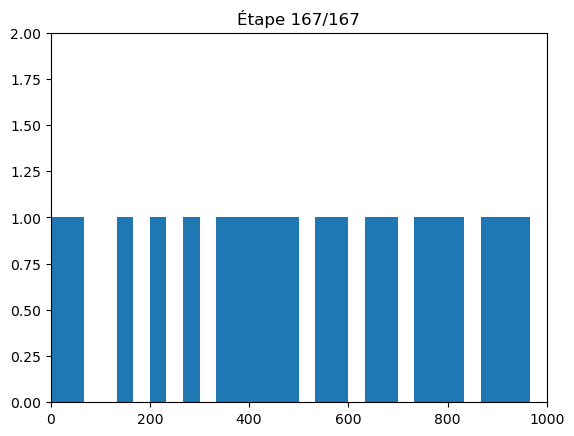

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def density(data):
    l=Paramroad["lengthroad"]
    s=10
    ninterval = l // s 
    lengthinterval = l//ninterval
    allposition=[]
    for listcar in data:
        positions=[car["position"] for car in listcar]
        positions.sort()
        allposition.append(positions)
    return allposition
class AnimatedHistogram:
    def __init__(self, allposition, n_bins, length):
        self.allposition = allposition
        self.n_bins = n_bins
        self.length = length
        self.fig, self.ax = plt.subplots()
        self.values, self.bins, self.patches = self.ax.hist([], bins=self.n_bins, range=(0, self.length))

    def init(self):
        for rect in self.patches:
            rect.set_height(0)
        return self.patches

    def update(self, step):
        self.ax.cla()
        self.ax.set_xlim(0, self.length)
        self.ax.set_ylim(0, np.max(self.values) + 1)

        self.values, self.bins, self.patches = self.ax.hist(self.allposition[step], bins=self.n_bins, range=(0, self.length))

        self.ax.set_title(f"Étape {step+1}/{len(self.allposition)}")

        return self.patches

    def animate(self):
        anim = animation.FuncAnimation(self.fig, self.update, frames=len(self.allposition), init_func=self.init, blit=True)
        anim.save('animation.gif', writer='pillow')
        
        # Afficher l'animation
        plt.show()
def moyennemobile(allposition,n):
    n = len(allposition)
    moyennemobile = []

    # Parcourir les indices des listes dans allposition
    for i in range(n):
        # Déterminer les indices des listes autour de la liste courante
        start_index = max(0, i - n//2)
        end_index = min(n, i + n//2+1)
        # Calculer la moyenne des listes autour de la liste courante
        average_list = np.mean(allposition[start_index:end_index], axis=0)
        # Ajouter la moyenne à la liste moyennemobile
        moyennemobile.append(average_list)
    return moyennemobile   
            
            
# Utilisation de la classe AnimatedHistogram
n_bins = 20  # Nombre d'intervalles
l = Paramroad["lengthroad"]
allposition = density(data)  # Vos données d'histogramme

histogram = AnimatedHistogram(allposition, n_bins, l)
histogram.animate()

In [ ]:
print(len(allposition))
for i in allposition:
    print (len(i))
plt.hist(allposition[100], bins=50)
plt.show()

In [ ]:
show_pygame(data,delta_t)